<a href="https://colab.research.google.com/github/acollin19/comp551_A1/blob/main/assignment1_group_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1

## Process:
### Dataset 1: Hepatitis
* Task 1 : Preprocessing
    1. Preprocessing
    2. Distributions
* Task 2 : Implemenmting KNN and DT
    1. KNN
    2. DT
* Task 3 : Running Experiments
    1. Compare accuracy
    2. Different K values
    3. Max tree depth
    4. Different distance/costs
    5. Plots
    6. Key features in DT
    7. Key features in KNN

### Dataset 2: Messidor features
* Task 1 : Preprocessing
    1. Preprocessing
    2. Distributions
* Task 2 : Implemenmting KNN and DT
    1. KNN
    2. DT
* Task 3 : Running Experiments
    1. Compare accuracy
    2. Different K values
    3. Max tree depth
    4. Different distance/costs
    5. Plots
    6. Key features in DT
    7. Key features in KNN


In [117]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
np.random.seed(1)

In [118]:
# Arff file to csv from https://github.com/mfahadzafar/Convert-Arff-to-CSV/blob/master/arffToCsv.py
def getCSVFromArff(fileName):
    with open(fileName + '.arff', 'r') as fin:
        data = fin.read().splitlines(True)
        i = 0
    cols = []
    for line in data:
        line = line.lower()
        if ('@data' in line):
            i+= 1
            break
        else:
            #print line
            i+= 1
            if (line.startswith('@attribute')):
                if('{' in line):
                    cols.append(line[11:line.index('{')-1])
                else:
                    cols.append(line[11:line.index(' ', 11)])
    headers = ",".join(cols)
    with open(fileName + '.csv', 'w') as fout:
        fout.write(headers)
        fout.write('\n')
        fout.writelines(data[i:])

getCSVFromArff("messidor_features") #outputs a csv file into dir

In [119]:
# Loading/cleaning datasets
hepatitis = pd.read_csv("hepatitis.data", header=None)
hepatitis = hepatitis[(hepatitis != '?').all(axis=1)]
hepatitis = hepatitis.dropna().reset_index(drop=True)

hepatitis.apply(pd.to_numeric)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,2,34,1,2,2,2,2,2,2,2,2,2,2,2,0.9,95,28,4.0,75,1
1,2,39,1,1,1,2,2,2,1,1,2,2,2,2,1.3,78,30,4.4,85,1
2,2,32,1,2,1,1,2,2,2,1,2,1,2,2,1.0,59,249,3.7,54,1
3,2,41,1,2,1,1,2,2,2,1,2,2,2,2,0.9,81,60,3.9,52,1
4,2,30,1,2,2,1,2,2,2,1,2,2,2,2,2.2,57,144,4.9,78,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,2,45,1,2,1,2,2,2,2,2,2,2,2,2,1.3,85,44,4.2,85,2
76,1,49,1,1,2,1,1,2,2,2,1,1,2,2,1.4,85,70,3.5,35,2
77,2,31,1,1,2,1,2,2,2,2,2,2,2,2,1.2,75,173,4.2,54,2
78,2,53,2,1,2,1,2,2,2,2,1,1,2,1,1.5,81,19,4.1,48,2


### Hepatitis Attribute Information:

1. Class: DIE, LIVE 
2. AGE: 10, 20, 30, 40, 50, 60, 70, 80 
3. SEX: male, female 
4. STEROID: no, yes 
5. ANTIVIRALS: no, yes 
6. FATIGUE: no, yes 
7. MALAISE: no, yes 
8. ANOREXIA: no, yes 
9. LIVER BIG: no, yes 
10. LIVER FIRM: no, yes 
11. SPLEEN PALPABLE: no, yes 
12. SPIDERS: no, yes 
13. ASCITES: no, yes 
14. VARICES: no, yes 
15. BILIRUBIN: 0.39, 0.80, 1.20, 2.00, 3.00, 4.00  
16. ALK PHOSPHATE: 33, 80, 120, 160, 200, 250 
17. SGOT: 13, 100, 200, 300, 400, 500, 
18. ALBUMIN: 2.1, 3.0, 3.8, 4.5, 5.0, 6.0 
19. PROTIME: 10, 20, 30, 40, 50, 60, 70, 80, 90 
20. HISTOLOGY: no, yes 



## Task 1.2 : Distributions

In [120]:
# Hepatitis Dataset
X = hepatitis.iloc[:, hepatitis.columns != 0].values # x -> features (1-19)
y = hepatitis.iloc[:, 0].values # y -> class label (0)
display(X)

array([[34, 1, '2', ..., '4.0', '75', 1],
       [39, 1, '1', ..., '4.4', '85', 1],
       [32, 1, '2', ..., '3.7', '54', 1],
       ...,
       [31, 1, '1', ..., '4.2', '54', 2],
       [53, 2, '1', ..., '4.1', '48', 2],
       [43, 1, '2', ..., '3.1', '42', 2]], dtype=object)

In [121]:
# Split Training and Testing without sklearn
split = 0.8
n_train = math.floor(split * X.shape[0])
n_test = math.ceil(1-split * X.shape[0])
X_train = X[:n_train]
y_train = y[:n_train]
X_test = X[n_train:]
y_test = y[n_train:]
print("Total Number of rows in train:",X_train.shape[0])
print("Total Number of rows in test:",X_test.shape[0])

#Instead of
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=2, shuffle=True)

Total Number of rows in train: 64
Total Number of rows in test: 16


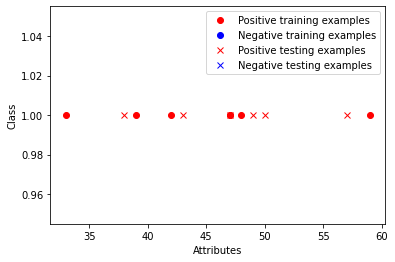

In [122]:
# Plotting
plt.clf()

positive_train = y_train == 1
negative_train = y_train == 0

positive_test = y_test == 1
negative_test = y_test == 0

plt.plot(X_train[positive_train,0],X_train[positive_train,1],"or",label="Positive training examples")
plt.plot(X_train[negative_train,0],X_train[negative_train,1],"ob",label="Negative training examples")

plt.plot(X_test[positive_test,0],X_test[positive_test,1],"xr",label="Positive testing examples")
plt.plot(X_test[negative_test,0],X_test[negative_test,1],"xb",label="Negative testing examples")

plt.xlabel("Attributes")
plt.ylabel("Class")
plt.legend(loc='best')
plt.savefig("hepatitis_dist.png", bbox_inches='tight', dpi=300)

## Task 2 : K-Nearest Neighbour

In [123]:
knn = KNeighborsClassifier() # n_neighbors=5 (default)
classifier = knn.fit(X_train, y_train)

# Evaluating prediction accuracy on training data
y_train_pred = classifier.predict(X_train)
y_test_pred = classifier.predict(X_test)

acc_train = np.sum(y_train_pred==y_train)/len(y_train)
acc_test = np.sum(y_test_pred==y_test)/len(y_test)

print(f'Training Accuracy: {acc_train}')
print(f'Testing Accuracy: {acc_test}')

Training Accuracy: 0.890625
Testing Accuracy: 0.625


## Task 2.2 : Decision Trees

# Dataset 2 : Messidor Features

## Task 1.1 Preprocessing

In [124]:
features = pd.read_csv('messidor_features.csv')
features = features[(features != '?').all(axis=1)]
features = features.dropna().reset_index(drop=True)
features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,class
0,1,1,22,22,22,19,18,14,49.895756,17.775994,5.270920,0.771761,0.018632,0.006864,0.003923,0.003923,0.486903,0.100025,1,0
1,1,1,24,24,22,18,16,13,57.709936,23.799994,3.325423,0.234185,0.003903,0.003903,0.003903,0.003903,0.520908,0.144414,0,0
2,1,1,62,60,59,54,47,33,55.831441,27.993933,12.687485,4.852282,1.393889,0.373252,0.041817,0.007744,0.530904,0.128548,0,1
3,1,1,55,53,53,50,43,31,40.467228,18.445954,9.118901,3.079428,0.840261,0.272434,0.007653,0.001531,0.483284,0.114790,0,0
4,1,1,44,44,44,41,39,27,18.026254,8.570709,0.410381,0.000000,0.000000,0.000000,0.000000,0.000000,0.475935,0.123572,0,1


### Features Attribute Information:

0. The binary result of quality assessment. 0 = bad quality 1 = sufficient quality.
1. The binary result of pre-screening, where 1 indicates severe retinal abnormality and 0 its lack.  
* (2-7). The results of MA detection. Each feature value stand for the number of MAs found at the confidence levels alpha = 0.5,...,1, respectively.     
* (8-15). contain the same information as 2-7) for exudates. However, as exudates are represented by a set of points rather than the number of pixels constructing the lesions, these features are normalized by dividing the number of lesions with the diameter of the ROI to compensate different image sizes.   
16. The euclidean distance of the center of the macula and the center of the optic disc to provide important information regarding the patientâ€™s condition. This feature is also normalized with the diameter of the ROI.   
17. The diameter of the optic disc.   
18. The binary result of the AM/FM-based classification.   
19. Class label. 1 = contains signs of DR (Accumulative label for the Messidor classes 1, 2, 3), 0 = no signs of DR. 

## Task 1.2 Distributions

In [125]:
# Messidor features dataset
X = features.iloc[:,:-1].values # x -> features (0-18)
y = features.iloc[:,-1:].values # y -> class label (19)

# Split Training and Testing without sklearn
split = 0.8
n_train = math.floor(split * X.shape[0])
n_test = math.ceil(1-split * X.shape[0])
X_train = X[:n_train]
y_train = y[:n_train]
X_test = X[n_train:]
y_test = y[n_train:]
print("Total Number of rows in train:",X_train.shape[0])
print("Total Number of rows in test:",X_test.shape[0])

Total Number of rows in train: 920
Total Number of rows in test: 231


In [126]:
# Plotting
plt.clf()
positive_train = y_train == 1
negative_train = y_train == 0

positive_test = y_test == 1
negative_test = y_test == 0


<Figure size 432x288 with 0 Axes>

In [127]:

plt.plot(X_train[positive_train,0], X_train[positive_train,1],"or",label="Positive training examples")
plt.plot(X_train[negative_train,0], X_train[negative_train,1],"ob",label="Negative training examples")

plt.plot(X_test[positive_test,0], X_test[positive_test,1],"xr",label="Positive testing examples")
plt.plot(X_test[negative_test,0], X_test[negative_test,1],"xb",label="Negative testing examples")

plt.xlabel("Attributes")
plt.ylabel("Class")
plt.legend(loc='best')
plt.savefig("messidor_features_dist.png", bbox_inches='tight', dpi=300)

IndexError: ignored

## Task 2 : K-Nearest Neighbour

In [ ]:
knn = KNeighborsClassifier() # n_neighbors=5 (default)
classifier = knn.fit(X_train, y_train)

# Evaluating prediction accuracy on training data
y_train_pred = classifier.predict(X_train)
y_test_pred = classifier.predict(X_test)

acc_train = np.sum(y_train_pred==y_train)/len(y_train)
acc_test = np.sum(y_test_pred==y_test)/len(y_test)

print(f'Training Accuracy: {acc_train}')
print(f'Testing Accuracy: {acc_test}')

## Task 2.2 : Decision Trees